In [189]:
import geopandas as gpd
import rasterio
from shapely.geometry import box
from rasterio.plot import show
import pandas as pd
import pylab as plt
import numpy as np
from rasterstats import zonal_stats, point_query
import seaborn as sns

In [190]:
# local variable on my hard drive
data = '/Users/nicholasjones/Desktop/data'

## Datasets on urban heat in Johannesburg and Ekurhuleni: GIS demo
**Background.** The study Extreme Heat in Johannesburg and Ekurhuleni: Impacts and Mitigation Options created datasets on expected heat stress in current and future periods. The study was conducted as part of the National Treasury Cities Support Programme engagement on Extreme Heat in South African Cities and implemented by the World Bank and VITO with funding from the Swiss Secretariat for Economic Cooperation (SECO) and the City Resilience Program. The heat datasets were created using the UrbClim urban climate model together with field measurements collected by community volunteers.

**Dataset accessibility.** The data and paper are available at the following links:

Data: https://zenodo.org/records/6394130

Paper: https://www.sciencedirect.com/science/article/pii/S2212095522002498

**GIS applications.** Through intersecting the heat stress datasets with GIS point data (such as locations of schools, health facilities or train station) or polygon data (eg neighborhood boundaries) a variety of queries can be answered.

**Key information.** The GeoTiffs are in EPSG 4326 projection (WGS84).

**This demo notebook.** This code notebook demonstrates use of the datasets via open source code libraries in Python. It uses standard libraries for raster data analysis (Rasterio), vector data analysis (GeoPandas), and simple GIS queries (rasterstats). The steps illustrated are: (i) load and inspect a heat dataset; (ii) load Johannesburg Wards boundaries from a GeoJSON file; (iii) analyze heat disparities across wards; (iv) analyze heat disparities across train stations.


#### 1. Load and inspect one of the raster files (night-time UHI intensity)

In [221]:
# this code points Rasterio (a raster data library) towards the file on my hard drive
raster_file1=data+'/SA/T2M_daily_mean_min_topography_2001_2020.tif'
src = rasterio.open(raster_file1)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float32'), dtype('<U47')) -> None

In [192]:
# read the raster data
data1 = src.read(1)
data1[data1<0] = np.nan   # set values below zero as NaN

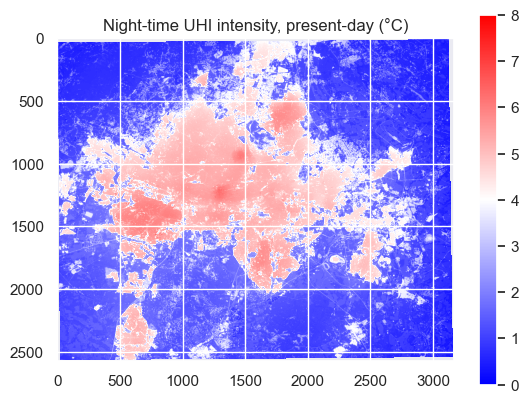

In [193]:
# plot the raster
ax = plt.imshow(data1,cmap='bwr',vmax=8)
plt.colorbar()
plt.title ('Night-time UHI intensity, present-day (°C)');

In [194]:
# what projection is it in?
src.crs

CRS.from_epsg(4326)

## 2. Load Ward boundaries for Johannesburg

In [197]:
# read ward boundaries from an online source (as a GeoDataFrame)
CoJ_wards = gpd.read_file('https://github.com/RyzorBent/za-geojson/raw/master/wards.json')

# only retain wards within the City of Johannesburg
CoJ_wards = CoJ_wards[CoJ_wards.municipalityName == 'City of Johannesburg Metropolitan Municipality'][['wardNo','geometry']]
CoJ_wards.head(2)

,wardNo,geometry
3179,1,"POLYGON ((27.85142 -26.47956, 27.84156 -26.485..."
3180,2,"POLYGON ((27.88277 -26.49234, 27.87291 -26.492..."


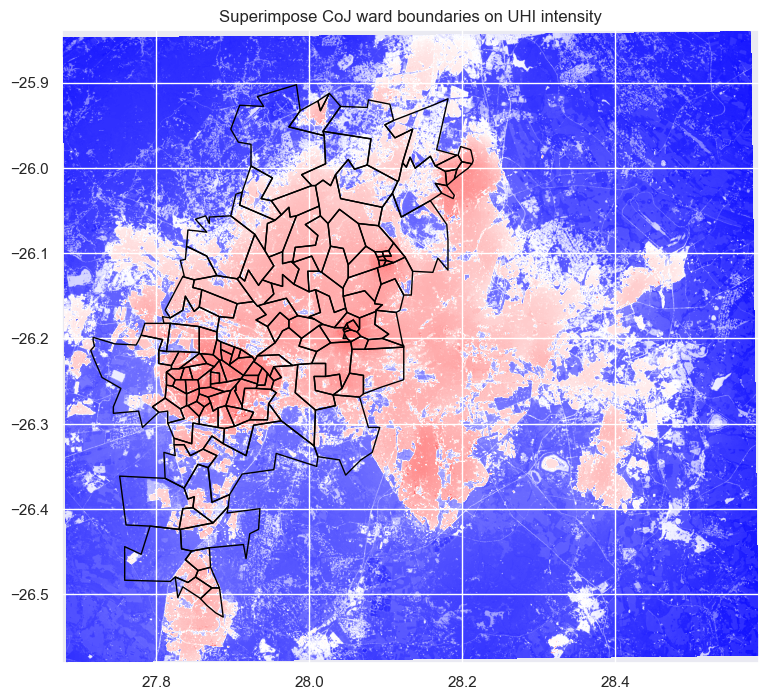

In [201]:
# plot and visually inspect
fig, ax = plt.subplots(figsize=[9,9])
show(src, ax=ax,cmap='bwr',vmax=8)
gdf.plot(ax=ax, color='none',edgecolor='black')
plt.title ('Superimpose CoJ ward boundaries on UHI intensity')
plt.show()

In [91]:
# save the boundaries to hard drive
CoJ_wards.to_file(data+'/heat/SA/CoJ_wards.shp')

## 3. Summarize heat island disparities between wards

In [202]:
# GIS query: get the mean pixel value in each ward (using Rasterstats library)
ward_UHI_means = zonal_stats(data+'/heat/SA/CoJ_wards.shp',raster_file1, stats="mean")

# tidy up the data
ward_UHI_means = [item['mean'] for item in ward_UHI_means]

In [203]:
# add to the dataframe and inspect
CoJ_wards['UHI_intensity'] = ward_UHI_means
CoJ_wards[['wardNo','UHI_intensity']]
CoJ_wards.sort_values('UHI_intensity',inplace=True, ascending=False)
CoJ_wards.head()

,wardNo,geometry,UHI_intensity
3241,63,"POLYGON ((28.05431 -26.18987, 28.05097 -26.187...",6.245029
3240,62,"POLYGON ((28.04445 -26.18987, 28.05097 -26.187...",6.206512
3237,59,"POLYGON ((28.04604 -26.19490, 28.04445 -26.199...",6.113005
3301,123,"POLYGON ((28.06259 -26.19231, 28.05431 -26.189...",6.078163
3254,76,"POLYGON ((28.11032 -26.11106, 28.10046 -26.108...",6.007011


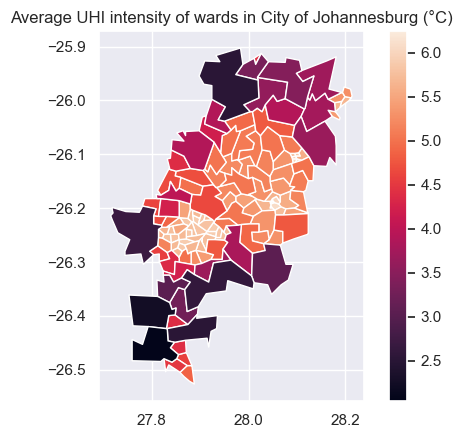

In [204]:
ax = CoJ_wards.plot(column='UHI_intensity', legend=True)
plt.title('Average UHI intensity of wards in City of Johannesburg (°C)');

In [205]:
# Rank the wards into quintiles (ie. five categories, each 20% of the wards).

CoJ_wards['UHI_quintile'] = pd.qcut(CoJ_wards.UHI_intensity, 5, labels=['low','low-medium','medium','high-medium','high'])

Text(0.5, 1.0, 'City of Johannesburg wards: UHI intensity (five categories)')

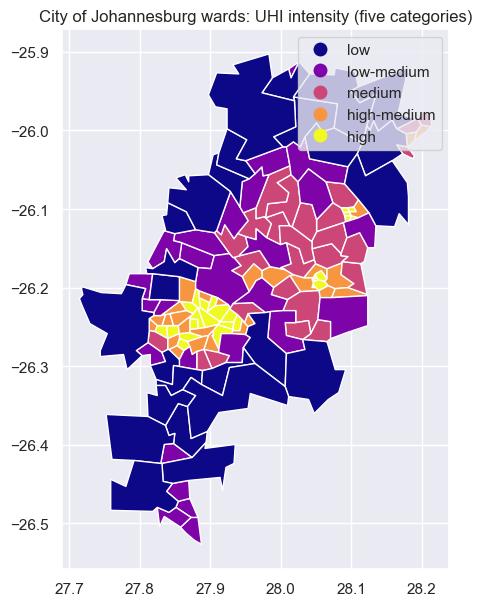

In [207]:
# Show as a map
f,ax = plt.subplots(figsize=[5,8])
CoJ_wards.plot(column='UHI_quintile', categorical = True, cmap='plasma',ax=ax, legend=True)
plt.title('City of Johannesburg wards: UHI intensity (five categories)')

In [208]:
# ten wards with highest UHI
CoJ_wards.head(5)

,wardNo,geometry,UHI_intensity,UHI_quintile
3241,63,"POLYGON ((28.05431 -26.18987, 28.05097 -26.187...",6.245029,high
3240,62,"POLYGON ((28.04445 -26.18987, 28.05097 -26.187...",6.206512,high
3237,59,"POLYGON ((28.04604 -26.19490, 28.04445 -26.199...",6.113005,high
3301,123,"POLYGON ((28.06259 -26.19231, 28.05431 -26.189...",6.078163,high
3254,76,"POLYGON ((28.11032 -26.11106, 28.10046 -26.108...",6.007011,high


In [209]:
# ten wards with lowest UHI
CoJ_wards.tail(5)

,wardNo,geometry,UHI_intensity,UHI_quintile
3300,122,"POLYGON ((28.00641 -26.32589, 27.96361 -26.296...",2.613735,low
3274,96,"POLYGON ((27.98827 -25.93305, 27.98334 -25.902...",2.517184,low
3184,6,"POLYGON ((27.93385 -26.42372, 27.93561 -26.399...",2.502895,low
3299,121,"POLYGON ((27.81180 -26.36393, 27.75244 -26.361...",2.239764,low
3183,5,"POLYGON ((27.82994 -26.42372, 27.79207 -26.419...",2.041721,low


## 4. Use case with point data: which train stations experience more hot days per year? How will this change in future? 
Summary:
* As well as UHI intensity, other important heat stress metrics are threshold based, eg. number of days per year where temperatures will exceed 30°C.
* This use illustrates intersecting GIS point data (specifically train station locations) with the threshold-based rasters.
* The use case can be extended to schools, clinics or other assets with a fixed location.

In [210]:
# import a shapefile showing the location of train stations (taken from OpenStreetMap)
shp = data+'/SA/shp/train_stations.shp'

gdf_transit = gpd.read_file(shp)

In [211]:
# point the computer towards the relevant raster files on local hard drive
# five rasters are used:
# * days above 30°C (present day)
# * days above 30°C (2040, low climate change scenario)
# * days above 30°C (2040, high climate change scenario)
# * days above 30°C (2060, low climate change scenario)
# * days above 30°C (2060, high climate change scenario)

fn_present=data+'/SA/T2M_dayover30_2001_2020.tif'
fn_2040_low=data+'/SA/T2M_dayover30_2021_2040_rcp45.tif'
fn_2040_high=data+'/SA/T2M_dayover30_2021_2040_rcp85.tif'
fn_2060_low=data+'/SA/T2M_dayover30_2041_2060_rcp45.tif'
fn_2060_high=data+'/SA/T2M_dayover30_2041_2060_rcp85.tif'

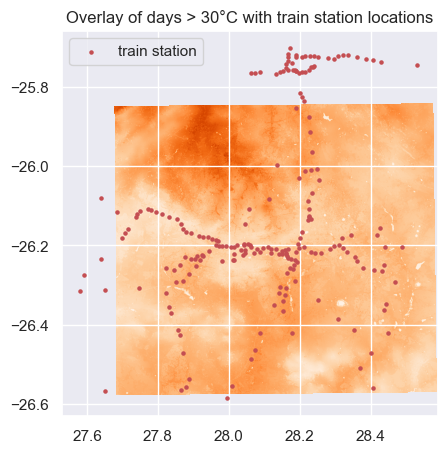

In [212]:
# plot on a map
src=rasterio.open(fn_present)
fig, ax = plt.subplots(figsize=[5,5])
show(src, ax=ax,cmap='Oranges')
gdf_transit.plot(ax=ax,color='r',markersize=5,label='train station')
plt.legend()
plt.title("Overlay of days > 30°C with train station locations");

In [213]:
data = src.read(1)
data[data<0] == np.nan
data[data<0].shape
data[data<0]=0


In [214]:
gdf_transit['present'] = point_query(shp,fn_present)
gdf_transit['2040_low'] = point_query(shp,fn_2040_low)
gdf_transit['2040_high'] = point_query(shp,fn_2040_high)
gdf_transit['2060_low'] = point_query(shp,fn_2060_low)
gdf_transit['2060_high'] = point_query(shp,fn_2060_high)

/Users/nicholasjones/opt/anaconda3/envs/geo1/lib/python3.7/site-packages/rasterstats/point.py:84: ShapelyDeprecationWarning: The 'array_interface_base' property is deprecated and will be removed in Shapely 2.0.
  arr = g.array_interface_base['data']


In [216]:
# the table of train station locations (added columns showing expected hot days per year)
gdf_transit

,element_ty,osmid,name,geometry,present,2040_low,2040_high,2060_low,2060_high
0,node,247644625,Driemanskap,POINT (28.35186 -26.41445),21.172493,31.394414,32.770257,43.252149,56.170231
1,node,247644654,Glenroy,POINT (28.30863 -26.38625),20.449202,29.420904,29.499626,39.478570,53.558773
2,node,247644683,Kaydale,POINT (28.40028 -26.47143),20.087113,29.201014,30.903085,41.209709,52.814324
3,node,247644703,Kraal,POINT (28.40597 -26.56182),17.450001,27.100000,28.950001,37.900002,50.150002
4,node,247644711,Mapleton,POINT (28.24974 -26.33807),22.966362,33.456477,35.523590,46.819020,60.065034
...,...,...,...,...,...,...,...,...,...
208,node,9165523933,Luipaardsvlei,POINT (27.81136 -26.11963),8.118537,14.623096,15.851262,23.856421,34.402696
209,node,9165523934,Witpoortjie,POINT (27.83141 -26.12732),9.219995,15.989862,17.152640,26.132385,37.162358
210,node,9165523935,Princess,POINT (27.85353 -26.13266),9.877367,17.015623,18.335412,27.341259,38.761112
211,node,9165523936,Horison,POINT (27.86376 -26.14642),16.182973,25.053794,26.528198,37.117346,50.085314


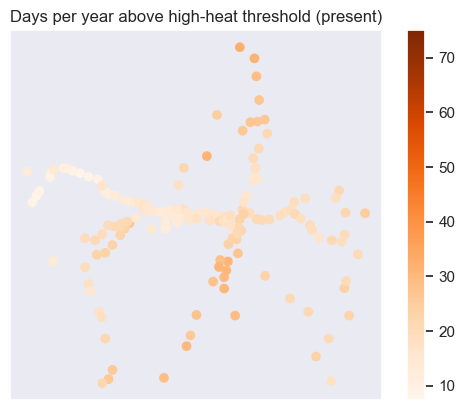

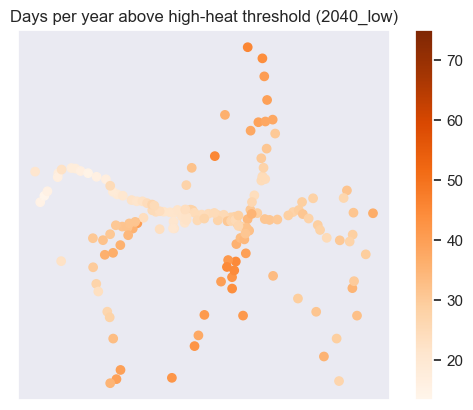

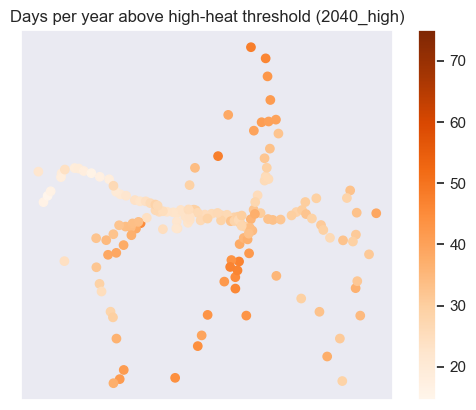

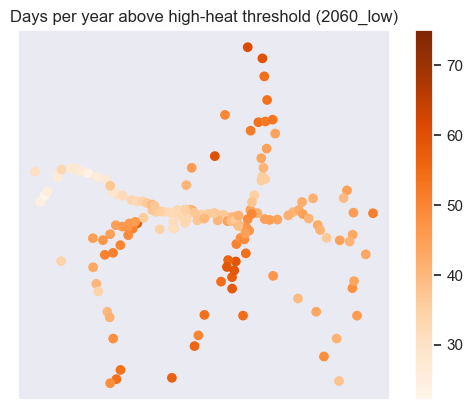

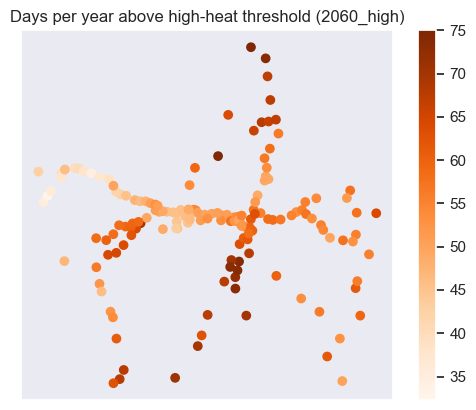

In [217]:
for column in ['present','2040_low','2040_high','2060_low','2060_high']:
    gdf_transit.plot(column=column,legend=True,vmax=75,cmap='Oranges')
    plt.title('Days per year above high-heat threshold ({})'.format(column))
    plt.gca().set(xticks=[], yticks=[])
    plt.show();

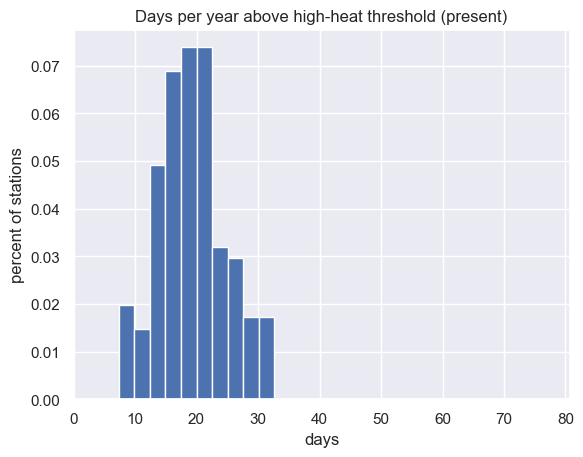

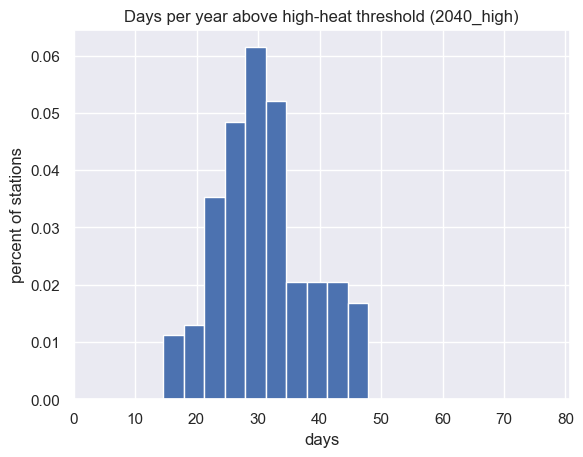

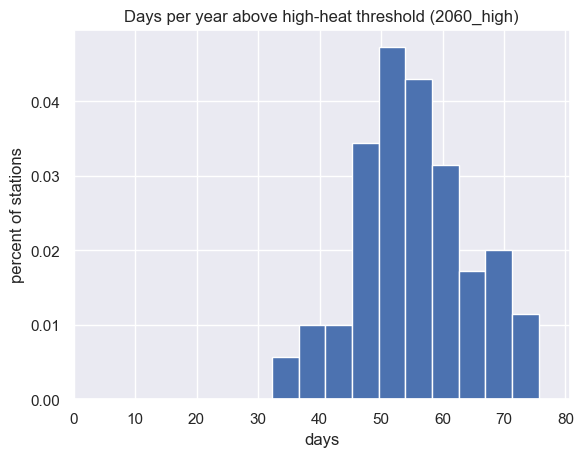

In [219]:
for column in ['present','2040_high','2060_high']:
    gdf_transit[column].hist(density=True)
    plt.xlim(0,gdf_transit['2060_high'].max()+5)
    plt.title('Days per year above high-heat threshold ({})'.format(column))
    plt.ylabel('percent of stations')
    plt.xlabel('days')
    plt.show()

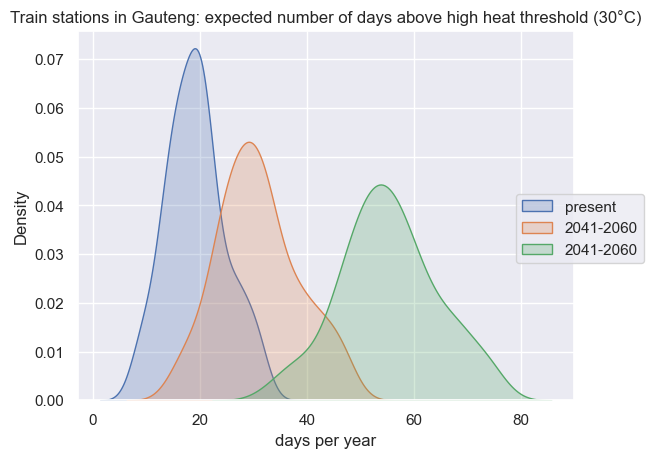

In [220]:
f,ax=plt.subplots()
sns.set(style="darkgrid")
sns.kdeplot(data=gdf_transit, x='present',fill=True,ax=ax)
sns.kdeplot(data=gdf_transit, x='2040_high',fill=True,ax=ax)
sns.kdeplot(data=gdf_transit, x='2060_high',fill=True,ax=ax)
f.legend(labels=['present','2041-2060','2041-2060'],loc='right')
plt.xlabel('days per year')
plt.title('Train stations in Gauteng: expected number of days above high heat threshold (30°C)')
plt.show();


This notebook was prepared in August 2024. Disclaimer: this notebook is created for technical demonstration purposes only and other source datasets (eg on Wards and train station locations) have not been checked for accuracy/timeliness.

For any questions please contact Nicholas Jones (njones@worldbank.org)